In [14]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples
import json
import pickle

In [16]:
def load_and_preprocess_data(filepath, sample_size=1000, random_state=42):
    """Load and preprocess the data with only MFCC features."""
    data = pd.read_csv(filepath)
    data_subset = data.sample(n=sample_size, random_state=random_state)
    
    # Select only MFCC features 1-25
    feature_columns = [f'mfcc{i}' for i in range(1, 26)]
    X = data_subset[feature_columns].values
    y = data_subset['class'].values
    
    print(f"Subset shape: {X.shape} - Processing {len(X)} samples with {len(feature_columns)} features")
    return X, y, feature_columns, data_subset

def prepare_train_test_data(X, y, test_size=0.3, random_state=42):
    """Split and scale the data."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [18]:
def train_gmm(X_train_scaled, n_components=9, random_state=42):
    """Initialize and train the GMM model."""
    gmm = GaussianMixture(
        n_components=n_components,
        random_state=random_state,
        covariance_type='tied',
        n_init=10,
        max_iter=1000,
        reg_covar=1e-3,
        init_params='kmeans',
        warm_start=True,
        verbose=1
    )
    
    print("\nFitting GMM model...")
    gmm.fit(X_train_scaled)
    return gmm

In [20]:
def analyze_clusters(clusters, y_test):
    """Analyze and print cluster statistics."""
    print("\nCluster Distribution (Test Set):")
    print("="*50)
    cluster_dist = pd.Series(clusters).value_counts().sort_index()
    for cluster, count in cluster_dist.items():
        percentage = (count/len(clusters))*100
        print(f"Cluster {cluster}: {count} samples ({percentage:.2f}%)")

    print("\nCluster vs Class Distribution:")
    print("="*50)
    cluster_class_df = pd.DataFrame({'Cluster': clusters, 'True_Class': y_test})
    confusion_matrix = pd.crosstab(
        cluster_class_df['Cluster'],
        cluster_class_df['True_Class'],
        normalize='index'
    ) * 100
    
    print("\nPercentage of classes in each cluster:")
    print(confusion_matrix)
    return confusion_matrix

def plot_cluster_class_distribution(confusion_matrix):
    """Plot the distribution of true classes within each cluster."""
    plt.figure(figsize=(12, 8))
    confusion_matrix.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Distribution of True Classes Within Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title='True Class', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

def visualize_clusters_umap(X_test_scaled, clusters, n_components):
    """Visualize clusters using UMAP projection."""
    # Visualize the clusters using UMAP for dimensionality reduction
    print("\nVisualizing clusters using UMAP...")
    reducer = umap.UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=30,        # Increased for smoother clustering
        min_dist=0.3,         # Increased for better cluster separation
        spread=1.0            # Added spread parameter for better scaling
    )
    X_test_umap = reducer.fit_transform(X_test_scaled)

    # Create figure with proper layout
    plt.figure(figsize=(15, 10))  # Larger figure size
    ax = plt.subplot(111)

    # Create scatter plot with improved aesthetics
    scatter = ax.scatter(X_test_umap[:, 0], X_test_umap[:, 1], 
                        marker='o', 
                        s=50,              # Larger points
                        alpha=0.6,         # Slightly less transparent
                        c=clusters,        # Direct cluster numbers for coloring
                        cmap='tab20',      # Different colormap for better distinction
                        edgecolor='none')  # Remove edge colors for cleaner look

    # Label the clusters more clearly
    cluster_centers = np.zeros((n_components, 2))
    for i in range(n_components):
        mask = clusters == i
        if np.any(mask):
            cluster_centers[i] = X_test_umap[mask].mean(axis=0)
            # Larger, more visible X markers
            ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1], 
                      marker='X', s=300, c='black', linewidth=2)
            # Improved label positioning and style
            ax.text(cluster_centers[i, 0], cluster_centers[i, 1], 
                   str(i), fontsize=14, weight='bold', 
                   ha='center', va='center',
                   color='white',
                   bbox=dict(facecolor='black', alpha=0.7, 
                            boxstyle='round,pad=0.5'))

    # Improve axes and title
    ax.set_title('GMM Clusters Visualization (UMAP Projection)', 
                fontsize=16, pad=20)
    ax.set_xlabel('UMAP Component 1', fontsize=12)
    ax.set_ylabel('UMAP Component 2', fontsize=12)

    # Add colorbar with better positioning
    plt.colorbar(scatter, ax=ax, label='Cluster', 
                ticks=range(n_components))

    # Add grid for better readability
    ax.grid(True, alpha=0.3)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [22]:
def calculate_cluster_metrics(X_test_scaled, clusters):
    """Calculate and print clustering metrics."""
    silhouette_avg = silhouette_score(X_test_scaled, clusters)
    davies_bouldin_avg = davies_bouldin_score(X_test_scaled, clusters)
    
    print(f"\nSilhouette Score: {silhouette_avg:.2f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_avg:.2f}")
    return silhouette_avg, davies_bouldin_avg

def plot_silhouette_analysis(X_test_scaled, clusters, n_components, silhouette_avg):
    """Plot silhouette analysis for the clusters."""
    # Visualize the silhouette scores for each sample
    print("\nVisualizing silhouette scores for each sample...")
    silhouette_values = silhouette_samples(X_test_scaled, clusters)
    y_lower = 10
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        ith_cluster_silhouette_values = silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_components)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), color='white', 
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))
        y_lower = y_upper + 10
    plt.title("Silhouette plot for the various clusters")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()

In [24]:
INPUT_FILE = 'data/processed_data_full.csv'
SAMPLE_SIZE = len(pd.read_csv(INPUT_FILE))  # Use all data instead of sampling
N_COMPONENTS = 9
RANDOM_STATE = 42

# Pipeline execution
X, y, feature_columns, data_subset = load_and_preprocess_data(
    INPUT_FILE, SAMPLE_SIZE, RANDOM_STATE
)

X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_train_test_data(
    X, y, random_state=RANDOM_STATE
)

gmm = train_gmm(X_train_scaled, N_COMPONENTS, RANDOM_STATE)

Subset shape: (179017, 25) - Processing 179017 samples with 25 features
Training set shape: (125311, 25), Testing set shape: (53706, 25)

Fitting GMM model...
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 1
  Iteration 10
Initialization converged.
Initialization 2
  Iteration 10
Initialization converged.
Initialization 3
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 4
  Iteration 10
Initialization converged.
Initialization 5
  Iteration 10
Initialization converged.
Initialization 6
  Iteration 10
Initialization converged.
Initialization 7
  Iteration 10
Initialization converged.
Initialization 8
Initialization converged.
Initialization 9
  Iteration 10
Initialization converged.



Silhouette Score: 0.16
Davies-Bouldin Score: 1.97

Visualizing silhouette scores for each sample...


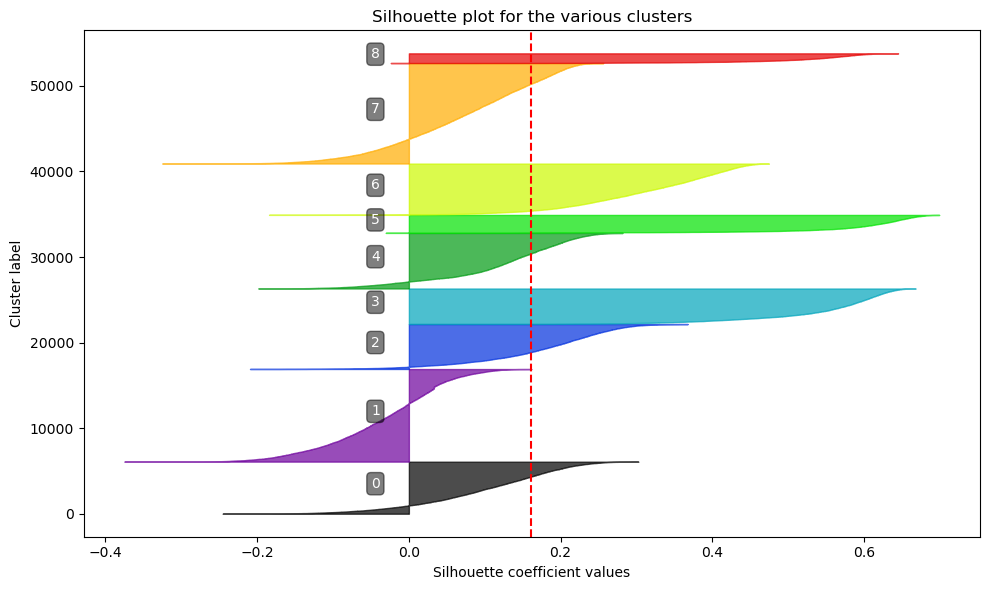


Cluster Distribution (Test Set):
Cluster 0: 6076 samples (11.31%)
Cluster 1: 10814 samples (20.14%)
Cluster 2: 5246 samples (9.77%)
Cluster 3: 4141 samples (7.71%)
Cluster 4: 6484 samples (12.07%)
Cluster 5: 2095 samples (3.90%)
Cluster 6: 5989 samples (11.15%)
Cluster 7: 11728 samples (21.84%)
Cluster 8: 1133 samples (2.11%)

Cluster vs Class Distribution:

Percentage of classes in each cluster:
True_Class    Bengali   Gujarati      Hindi    Kannada  Malayalam    Marathi  \
Cluster                                                                        
0            0.164582   0.740619   0.000000   1.826860  83.113891   0.049375   
1           27.455151  18.420566   5.899760   4.882560   9.348992  21.074533   
2            1.277164   0.266870   0.000000   2.077774   6.595501   0.114373   
3            0.000000   0.000000   0.000000  99.806810   0.096595   0.096595   
4            6.770512   0.632326  65.885256   2.544725   8.621221  15.129550   
5            0.000000   0.047733   0.00

<Figure size 1200x800 with 0 Axes>

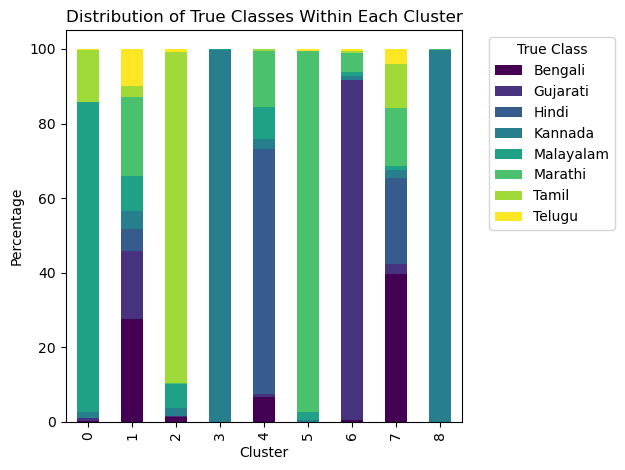


Visualizing clusters using UMAP...


/Applications/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


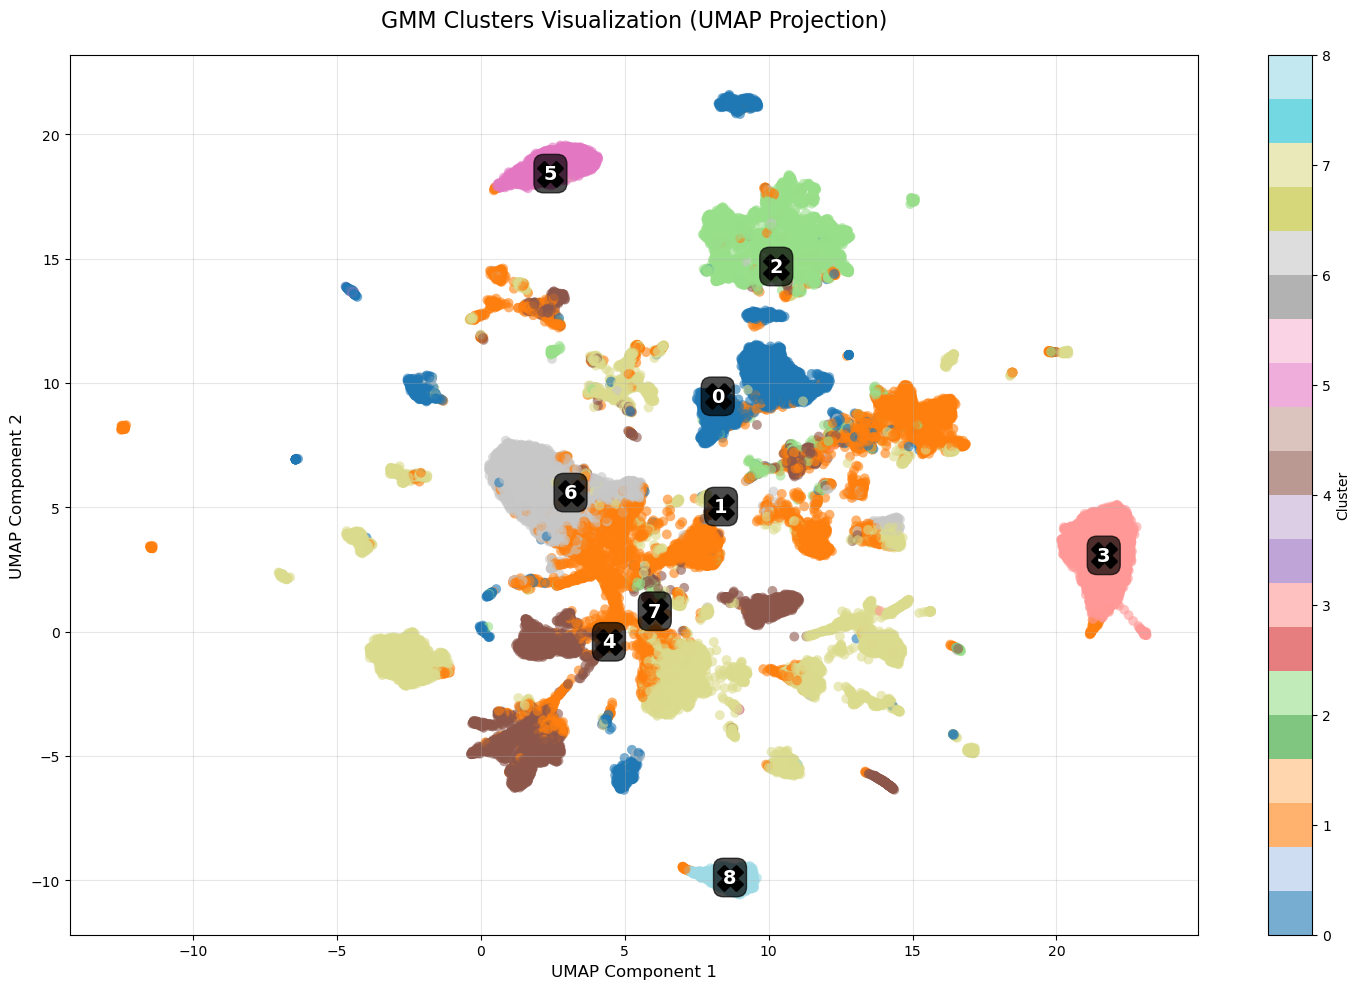

In [25]:
# Predict clusters for the test set
clusters = gmm.predict(X_test_scaled)

# Calculate and print clustering metrics
silhouette_avg, davies_bouldin_avg = calculate_cluster_metrics(X_test_scaled, clusters)

# Plot silhouette analysis
plot_silhouette_analysis(X_test_scaled, clusters, N_COMPONENTS, silhouette_avg)

# Analyze clusters
confusion_matrix = analyze_clusters(clusters, y_test)

# Plot cluster vs class distribution
plot_cluster_class_distribution(confusion_matrix)

# Visualize clusters using UMAP
visualize_clusters_umap(X_test_scaled, clusters, N_COMPONENTS)

In [26]:
# Calculate accuracy of GMM model
def calculate_gmm_accuracy(clusters, y_test):
    """Calculate the accuracy of the GMM model."""
    # Create a DataFrame to hold clusters and true class labels
    cluster_class_df = pd.DataFrame({'Cluster': clusters, 'True_Class': y_test})
    
    # Find the most frequent true class for each cluster
    cluster_to_class = cluster_class_df.groupby('Cluster')['True_Class'].agg(lambda x: x.value_counts().index[0])
    
    # Map clusters to the most frequent true class
    predicted_classes = cluster_class_df['Cluster'].map(cluster_to_class)
    
    # Calculate accuracy
    accuracy = (predicted_classes == y_test).mean()
    
    print(f"\nGMM Model Accuracy: {accuracy:.2f}")
    return accuracy

# Calculate and print GMM model accuracy
accuracy = calculate_gmm_accuracy(clusters, y_test)


GMM Model Accuracy: 0.64


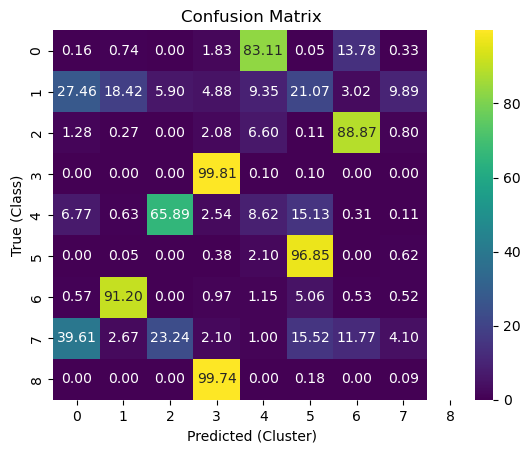

In [28]:
# Make a confusion matrix using seaborn
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='viridis', xticklabels=range(N_COMPONENTS), yticklabels=range(N_COMPONENTS))
plt.xlabel('Predicted (Cluster)')
plt.ylabel('True (Class)')
plt.title('Confusion Matrix')
plt.show()

In [29]:
#save this model
pickle.dump(gmm, open('models/gmm_model.pkl', 'wb'))

In [30]:
# Pipeline execution
X, y, feature_columns, data_subset = load_and_preprocess_data(
    INPUT_FILE, SAMPLE_SIZE, RANDOM_STATE
)

X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_train_test_data(
    X, y, random_state=RANDOM_STATE
)

Subset shape: (179017, 25) - Processing 179017 samples with 25 features
Training set shape: (125311, 25), Testing set shape: (53706, 25)


In [31]:
def train_ubm(X_train_scaled, n_components=512, random_state=42):
    """Train the Universal Background Model (UBM) with enhanced settings for better accuracy."""
    ubm = GaussianMixture(
        n_components=n_components,
        random_state=random_state,
        covariance_type='diag',
        n_init=10,  # Further increase the number of initializations for better convergence
        max_iter=1000,  # Further increase the maximum number of iterations
        reg_covar=1e-6,
        init_params='kmeans',
        verbose=1
    )
    
    print("\nTraining Universal Background Model...")
    ubm.fit(X_train_scaled)
    print("UBM training completed.")
    return ubm

def adapt_gmm(ubm, speaker_data, relevance_factor=16):
    """
    Adapt the UBM to create a speaker-specific GMM using MAP adaptation with optimized relevance factor.
    
    Args:
        ubm: Trained Universal Background Model
        speaker_data: Features for specific speaker/class
        relevance_factor: Controls adaptation strength (optimized for better accuracy)
    """
    n_samples = speaker_data.shape[0]
    print(f"\nAdapting GMM for speaker data with {n_samples} samples...")
    
    # Calculate sufficient statistics
    responsibilities = ubm.predict_proba(speaker_data)
    
    # Calculate zeroth and first order statistics
    n_k = responsibilities.sum(axis=0)
    f_k = np.dot(responsibilities.T, speaker_data)
    
    # Calculate adaptation alpha
    alpha_k = n_k / (n_k + relevance_factor)
    
    # Adapt means
    adapted_means = np.zeros_like(ubm.means_)
    for k in range(ubm.n_components):
        if n_k[k] > 0:
            adapted_means[k] = (alpha_k[k] * f_k[k] / n_k[k] + 
                                (1 - alpha_k[k]) * ubm.means_[k])
        else:
            adapted_means[k] = ubm.means_[k]
    
    print("GMM adaptation completed.")
    
    # Create adapted GMM
    adapted_gmm = GaussianMixture(
        n_components=ubm.n_components,
        covariance_type=ubm.covariance_type,
        random_state=ubm.random_state
    )
    
    # Set parameters from UBM and adapted means
    adapted_gmm.means_ = adapted_means
    adapted_gmm.covariances_ = ubm.covariances_
    adapted_gmm.weights_ = ubm.weights_
    adapted_gmm.precisions_cholesky_ = ubm.precisions_cholesky_
    
    return adapted_gmm

def score_gmm_ubm(ubm, adapted_gmm, test_data):
    """
    Calculate likelihood ratio scores with enhanced precision.
    
    Args:
        ubm: Universal Background Model
        adapted_gmm: Adapted speaker model
        test_data: Test features to score
    """
    ubm_scores = ubm.score_samples(test_data)
    gmm_scores = adapted_gmm.score_samples(test_data)
    likelihood_ratios = gmm_scores - ubm_scores
    return np.mean(likelihood_ratios)

def train_gmm_ubm_system(X_train_scaled, y_train, X_test_scaled, y_test):
    """Train and evaluate a complete GMM-UBM system with improved accuracy."""
    print("\nStarting GMM-UBM system training...")
    ubm = train_ubm(X_train_scaled)
    
    unique_classes = np.unique(y_train)
    adapted_models = {}
    
    for class_label in unique_classes:
        print(f"Adapting model for class {class_label}...")
        class_data = X_train_scaled[y_train == class_label]
        adapted_models[class_label] = adapt_gmm(ubm, class_data)
    
    print("All class models adapted. Starting evaluation on test set...")
    
    results = []
    for test_idx in range(len(X_test_scaled)):
        test_sample = X_test_scaled[test_idx:test_idx+1]
        true_label = y_test[test_idx]
        
        scores = {}
        for class_label, model in adapted_models.items():
            scores[class_label] = score_gmm_ubm(ubm, model, test_sample)
        
        predicted_label = max(scores.items(), key=lambda x: x[1])[0]
        
        results.append({
            'true_label': true_label,
            'predicted_label': predicted_label,
            'scores': scores
        })
    
    print("Evaluation completed.")
    return results, ubm, adapted_models

In [32]:
#undersample the data to 1000 samples
X_train_scaled = X_train_scaled[:100000]
X_test_scaled = X_test_scaled[:100000]

#undersample the y_train and y_test to 1000 samples
y_train = y_train[:100000]
y_test = y_test[:100000]



# Replace your existing GMM training with:
results, ubm, adapted_models = train_gmm_ubm_system(
    X_train_scaled, y_train, X_test_scaled, y_test
)

# Calculate accuracy
predictions = [r['predicted_label'] for r in results]
accuracy = np.mean(np.array(predictions) == y_test)
print(f"\nGMM-UBM System Accuracy: {accuracy:.2f}")


Starting GMM-UBM system training...

Training Universal Background Model...
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
Initialization 1
  Iteration 10
Initialization converged.
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
Initialization 4
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 5
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
Initialization 6
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
Initialization 7
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
Initialization 8
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 9
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
UBM training completed.
Adapting model for class Bengali...

Adapting GMM for speaker data with 15226 samples...
GMM a

In [39]:
# save this model
pickle.dump(ubm, open('models/ubm_model.pkl', 'wb'))
pickle.dump(adapted_models, open('models/gmm_ubm_adapted_models.pkl', 'wb'))


Cluster Distribution (Test Set):
Cluster Bengali: 6947 samples (12.94%)
Cluster Gujarati: 7007 samples (13.05%)
Cluster Hindi: 5249 samples (9.77%)
Cluster Kannada: 8200 samples (15.27%)
Cluster Malayalam: 6757 samples (12.58%)
Cluster Marathi: 7307 samples (13.61%)
Cluster Tamil: 6789 samples (12.64%)
Cluster Telugu: 5450 samples (10.15%)

Cluster vs Class Distribution:

Percentage of classes in each cluster:
True_Class    Bengali   Gujarati      Hindi    Kannada  Malayalam    Marathi  \
Cluster                                                                        
Bengali     45.832734   6.952641   9.658846  17.100907   3.800202  13.746941   
Gujarati    10.931925  50.777794   3.282432   1.812473  10.974740  10.989011   
Hindi        8.077729   4.877119  65.307678   0.857306   5.048581  10.097161   
Kannada     12.841463   9.682927  10.426829  39.304878  13.890244   3.975610   
Malayalam   15.361847  11.025603   4.277046   2.515909  49.652213   3.818263   
Marathi      8.060764  11

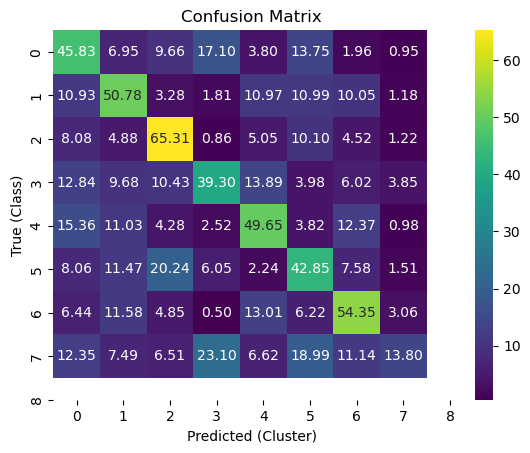

In [40]:
# make a confusion matrix for the gmm ubm using seaborn
confusion_matrix = analyze_clusters(predictions, y_test)
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='viridis', xticklabels=range(N_COMPONENTS), yticklabels=range(N_COMPONENTS))
plt.xlabel('Predicted (Cluster)')
plt.ylabel('True (Class)')
plt.title('Confusion Matrix')
plt.show()